# Colllected cluster IDs and organize data for nirB (K00362)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mgsa.helpers import plot
from mgsa.io import get_data

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

First, collect unique variant IDs

In [5]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
from mgsa.io import get_filepath, find_orfs, find_cluster_from_orf
import numpy as np

ORFs = find_orfs('../data/KO_subsets/subset_K00362/T0.coassembly_annotations_K00362.tsv', 'K00362')
ORF_list = list(ORFs)
print('\n ORFs \n')
print(ORF_list)
Cluster_IDs_nir = ORF_list
for i, orf in enumerate(ORF_list):
    prefix = orf.split('.')[0]
    Cluster_IDs_nir[i] = find_cluster_from_orf(ORF_list[i], KO='K00362')
    print(Cluster_IDs_nir[i])
print('\n Clusters \n')
print(Cluster_IDs_nir)

IDs = np.array(Cluster_IDs_nir)
print(len(IDs))
unique_IDs = np.unique(IDs)
print(len(unique_IDs))

np.savetxt("../out/orf_ids/cluster_ids_09_K00362.tsv", unique_IDs, delimiter = '\t', fmt = '%s')

    


 ORFs 

['T0.scaffold_965050734_c1_1', 'T0.scaffold_674264173_c1_2', 'T0.scaffold_235407460_c1_1', 'T0.scaffold_425704581_c1_1', 'T0.scaffold_1046518665_c1_1', 'T0.scaffold_1139748875_c1_1', 'T0.scaffold_851956514_c1_8', 'T0.scaffold_409661293_c1_1', 'T0.scaffold_398332474_c1_2', 'T0.scaffold_476022968_c1_1', 'T0.scaffold_971669607_c1_3', 'T0.scaffold_755447036_c1_1', 'T0.scaffold_694788772_c1_1', 'T0.scaffold_426955703_c1_1', 'T0.scaffold_264933928_c1_1', 'T0.scaffold_600798551_c1_1', 'T0.scaffold_626035696_c1_1', 'T0.scaffold_811256756_c1_1', 'T0.scaffold_179219282_c1_1', 'T0.scaffold_693816164_c1_1', 'T0.scaffold_438706182_c1_4', 'T0.scaffold_854879765_c1_1', 'T0.scaffold_985364849_c1_1', 'T0.scaffold_812619765_c1_1', 'T0.scaffold_570536390_c1_1', 'T0.scaffold_800300241_c1_1', 'T0.scaffold_426955704_c1_1', 'T0.scaffold_1072865172_c1_3', 'T0.scaffold_226587409_c1_1', 'T0.scaffold_874310118_c1_2', 'T0.scaffold_235715114_c1_1', 'T0.scaffold_622577224_c1_1', 'T0.scaffold_288001592_c1_1

Now that we have a list of 734 nirB variants, we map the incomplete variants to the complete ones. Then perform hierarchical clustering in the usual way. 

In [6]:

#load in the mapping
KO = 'K00362'
map = '09'
Drug = 'None'

all_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', sep = '\t', header=None)

map = pd.read_csv(f'../out/aaseqs/{KO}/incomplete_to_complete_seq_mapping.tsv', sep = '\t').values

complete_ids = pd.read_csv(f'../out/aaseqs/{KO}/long_complete_orf_ids.txt', header = None)
complete_ids = complete_ids.values

T0data = np.zeros((len(complete_ids), 20))
T9data = np.zeros((len(complete_ids), 10, 11))

for i, id in enumerate(complete_ids):
    got_data = get_data(id, drug = Drug, KO=KO)
    T0data[i] += got_data[0]
    T9data[i] += got_data[1]

for i, id in enumerate(map[:,0]):
    complete_id = map[i, 1]
    idx = np.where(complete_ids == complete_id)[0][0]
    got_data = get_data(id, drug = Drug, KO='K00362')
    T0data[idx] += got_data[0]
    T9data[idx] += got_data[1]




In [7]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# strc_data = pd.read_csv(f'../out/structure_analysis/{KO}/structure_metrics_{KO}.tsv', sep='\t')
# strc_data = strc_data.values
# strc_data = strc_data[:, 1:]#remove the first column (orf names)

scaler = MinMaxScaler()
# strc_data = scaler.fit_transform(strc_data)


data_abs = T0data
T0data = T0data / T0data.sum(axis = 1, keepdims=True)
T0data = np.nan_to_num(T0data, nan = 0)

data = T0data 
for i in range(10):
    T9temp = T9data[:,i,:]
    data_abs = np.hstack((data_abs, T9temp))
    T9temp = T9temp / T9temp.sum(axis = 1, keepdims=True)
    T9temp = np.nan_to_num(T9temp, nan = 0)
    data = np.hstack((data, T9temp))
    

pairwise_data = np.load(f'../out/aaseqs/{KO}/long_complete_pwalignment_scores.npy')
print(pairwise_data)
pairwise_data = scaler.fit_transform(pairwise_data)
data = np.hstack((data, pairwise_data))
data_abs = np.hstack((data_abs, pairwise_data))
#data = np.hstack((data, strc_data))


weights = np.concatenate([
    np.full(20, 1/np.sqrt(20)),    
    np.full(110, 1/np.sqrt(110)),  
    np.full(62, 1/np.sqrt(62))       
])




weighted_data = data * weights 



[[4445. 2171. 2248. ... 2360. 2307. 2086.]
 [2171. 4362. 2913. ... 2090. 2732. 2797.]
 [2248. 2913. 4375. ... 2208. 3051. 2629.]
 ...
 [2360. 2090. 2208. ... 4335. 2159. 2020.]
 [2307. 2732. 3051. ... 2159. 4307. 2606.]
 [2086. 2797. 2629. ... 2020. 2606. 4437.]]


[25, 54, 5, 8, 58, 27, 26, 48, 17, 29, 33, 60, 2, 13, 44, 1, 15, 9, 3, 47, 56, 43, 40, 61, 35, 23, 34, 24, 11, 12, 41, 55, 7, 28, 6, 39, 45, 37, 21, 42, 36, 30, 46, 51, 0, 57, 20, 14, 50, 18, 10, 59, 53, 16, 52, 19, 49, 31, 38, 4, 22, 32]


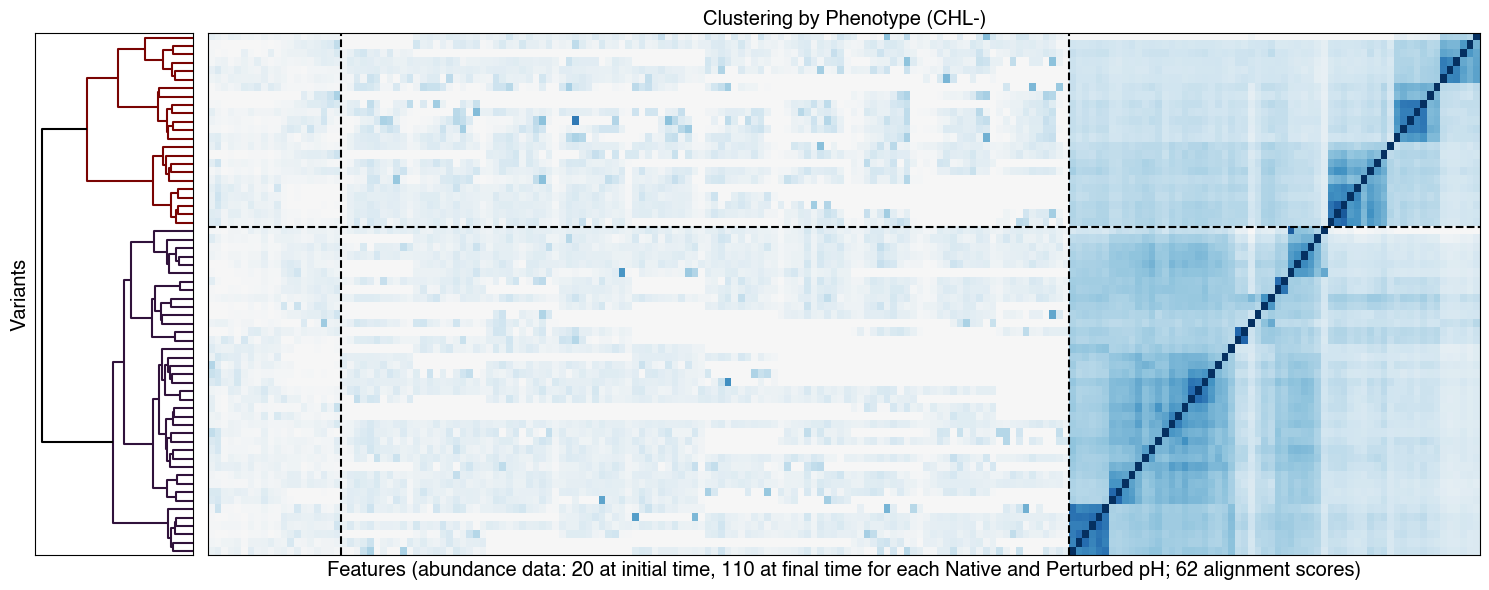

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import pdist
from matplotlib.colors import to_hex


Z = linkage(weighted_data, method='ward', metric='euclidean')
Z_optimal = optimal_leaf_ordering(Z, pdist(data, metric='euclidean'))

n_clusters = 2
clusters = fcluster(Z_optimal, t=n_clusters, criterion='maxclust')

dendro = dendrogram(Z_optimal, no_plot=True)
leaf_indices = dendro['leaves']

idx_to_cluster = {i: clusters[i] for i in range(len(clusters))}


next_node = len(clusters)
node_to_cluster = {}

for i, (left, right, _, _) in enumerate(Z_optimal):
    left, right = int(left), int(right)
    left_cluster = idx_to_cluster.get(left, node_to_cluster.get(left, -1))
    right_cluster = idx_to_cluster.get(right, node_to_cluster.get(right, -1))
    if left_cluster == right_cluster and left_cluster != -1:
        node_to_cluster[next_node] = left_cluster
    next_node += 1
    
    

#cluster_colors = ['#1f77b4', "#9729E0", "#610a70", "#210bcb"]
cmap = plt.cm.turbo # Or any other colormap (e.g., 'viridis', 'plasma')
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    cluster_id = node_to_cluster.get(link_idx, -1)
    if cluster_id != -1 and cluster_id <= len(cluster_colors):
        return cluster_colors[cluster_id - 1]
    return "#000000"  # default color for unclustered links


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [0.5, 4]})

dendrogram(Z_optimal,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z_optimal[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Variants', fontname='Helvetica', fontsize = 'x-large')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.tick_params(left=False, bottom=False)

data = np.array(data)

rearranged_data = data[leaf_indices]
col_leaf_indices = leaf_indices+130*np.ones(62, dtype = int)
rearranged_data[:, 130:192] = rearranged_data[:, col_leaf_indices]

im = ax2.imshow(rearranged_data, aspect='auto', cmap='RdBu',
                interpolation='nearest', origin='lower', vmin = -1, vmax = 1)
#plt.colorbar(im, ax=ax2)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')
    
ax2.axvline(19.5, color='black', linestyle='--')
ax2.axvline(129.5, color='black', linestyle='--')
ax2.set_xticks([])

ax2.set_title('Clustering by Phenotype (CHL-)', fontname='Helvetica', fontsize = 'x-large')
ax2.set_xlabel('Features (abundance data: 20 at initial time, 110 at final time for each Native and Perturbed pH; 62 alignment scores)', fontname='Helvetica', fontsize = 'x-large')

#ax2.set_ylabel('Variants', fontname='Helvetica', fontsize='x-large')

ax2.set_yticks([])
ax2.set_yticks([])
plt.tight_layout()

print(leaf_indices)
    
plt.show()

(62, 192)
(62, 192)
[38]


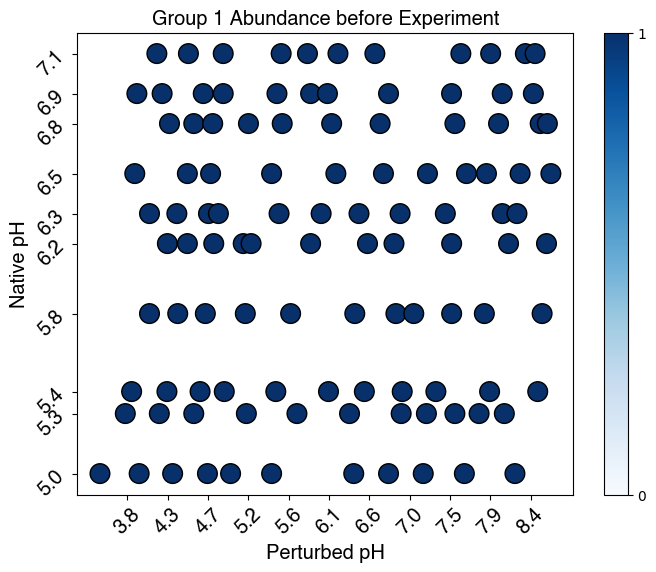

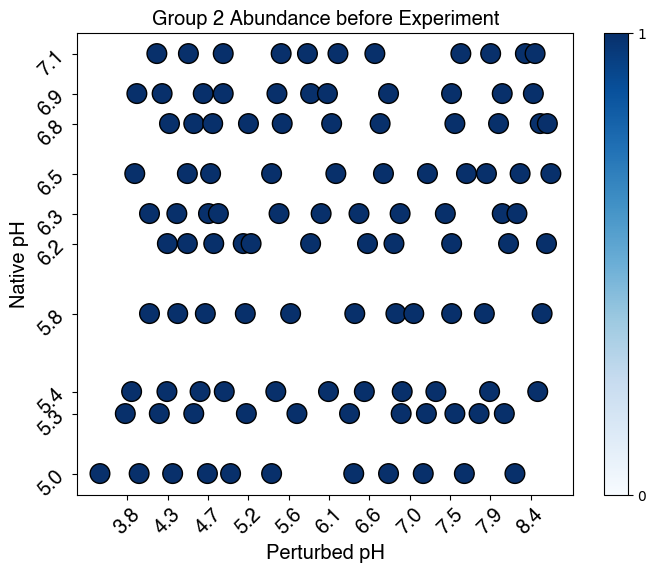

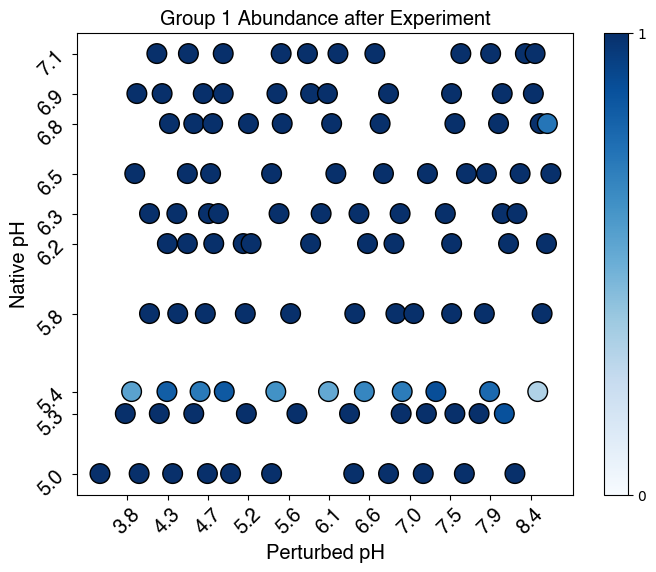

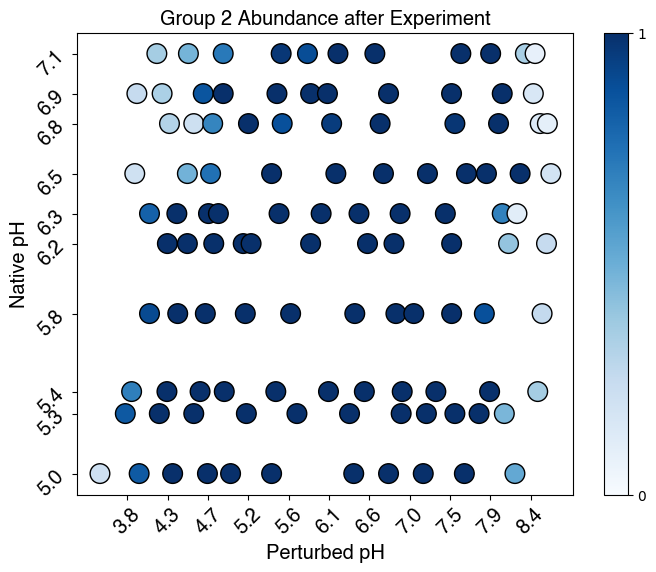

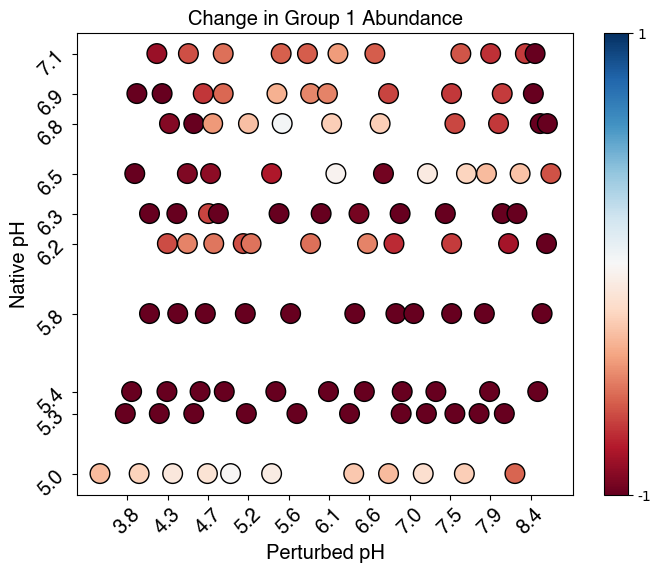

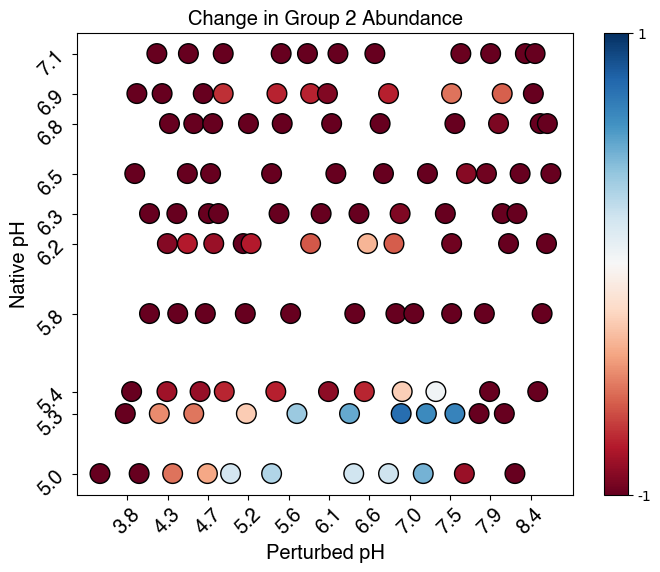

In [17]:

new_data = data_abs[leaf_indices]

print(data.shape)
print(new_data.shape)
print(boundaries)


groups = np.zeros((n_clusters,192))

for i, datum in enumerate(new_data):
    for j in range(1, n_clusters-1):
        if i > boundaries[j - 1] and i < boundaries[j]:
            groups[j] += datum
    if i < boundaries[0]:
        groups[0] += datum
    elif i > boundaries[n_clusters-2]:
        groups[n_clusters-1] += datum




selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]

#T0
groups_T0 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(n_clusters):
        groups_T0[j][i] = groups[j][selected][i]
        
for j in range(n_clusters):
    plot(groups_T0[j], f'Group {j+1} Abundance before Experiment', vmin = 0, vmax = 1)

#T9
groups_T9 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(11): #perturbed pH
        for k in range(n_clusters):
            groups_T9[k][i][j] = groups[k][20 + 11*i + j]
            
for i in range(n_clusters):
    plot(groups_T9[i],  f'Group {i+1} Abundance after Experiment', vmin = 0, vmax = 1)
        
for i in range(n_clusters):
    plot(np.log((groups_T9[i] + 0.01*np.ones_like(groups_T9[i])) /  (groups_T0[i]+ 0.01 * np.ones_like(groups_T0[i]))), f'Change in Group {i+1} Abundance', vmin = -1, vmax = 1, cmap = 'RdBu')
    #plot(groups_T9[i] - groups_T0[i], 'change subtraction', cmap = 'RdBu', vmin = -1, vmax = 1)

#change



In [ ]:
v1_clusters = []
for i in range(len(orf_list)):
    #print(orf_list[i], leaf_indices[i])
    cluster = 0
    if leaf_indices[i] < boundaries[0] + 0.5:
            cluster = 1
    for j in range(1, len(boundaries)):
        if leaf_indices[i] > boundaries[j-1] + 0.5 and leaf_indices[i] < boundaries[j]+0.5:
            cluster = j + 1
    j = len(boundaries) - 1
    if leaf_indices[i] > boundaries[j]+0.5:
        cluster = 7
    v1_clusters.append([orf_list[56-i], cluster])
    

for element in v1_clusters:
    print(element)
    
values = [item[1] for item in v1_clusters]
plt.hist(values)
print(values)

with open("../out/groups/assignments_v1.tsv", 'w') as f:
    for row in v1_clusters:
        f.write(f"{row[0]} {row[1]}\n")